<h1><center>Super Market Sales Analytics</center></h1>

<h2>1) Data Science Proposal</h2>

1. Get the data
2. Exploratory Analysis 
3. Data cleaning 
4. Select a model and train it 
5. Fine-tune your model
6. Present the result 

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import skew
from prettytable import PrettyTable
from datetime import datetime

# For feature selections and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

# Clustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import silhouetteplot
import scipy.cluster.hierarchy as sch
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

# Importing the DecisionTreeClassifier and LogisticRegressionClassifier for model building
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

# For Analyzing the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
#Read Data from the csv file
df = pd.read_csv('Supermarket_Sales_Dataset.csv')
df.head(2)

Invoice ID Branch       City Customer Type  Gender  \
0  750-67-8428      A  Bangalore        Member  Female   
1  226-31-3081      C     Mysore        Normal  Female   

             Product Type  Unit Price  Quantity     Tax   Selling Price  \
0       Health and beauty       74.69         7  26.1415       548.9715   
1  Electronic accessories       15.28         5   3.8200        80.2200   

       Date   Time Payment Type  Cost Price  Gross Income  Rating  
0  1/5/2019  13:08   Debit card      522.83       26.1415     9.1  
1  3/8/2019  10:29         Cash       76.40        3.8200     9.6

In [3]:
#Defining class colour
class color:
   BLUE = '\033[94m'
   BOLD = '\033[1m'
   END = '\033[0m'

<h2>Objectives</h2>

<h5>1) Which city has a better sale for products in the Electronic Accessories product line? </h5>

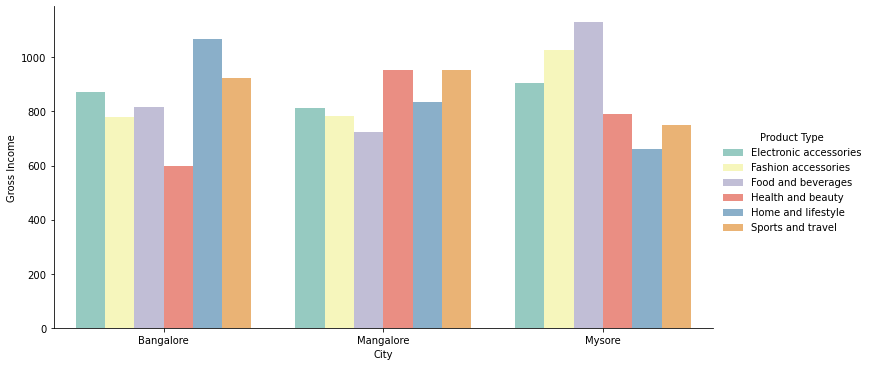

City            Product Type  Gross Income
12  Mysore  Electronic accessories      903.2845

In [4]:
dfCat=df[['City','Product Type','Gross Income']].groupby(['City','Product Type'],as_index=False).sum()
sns.catplot(data=dfCat, y='Gross Income', x='City',kind='bar', hue='Product Type',height=5,aspect=2,palette="Set3")
plt.show()

dfCat[dfCat['Product Type'] == 'Electronic accessories'].nlargest(1,'Gross Income')

<h5>2) Which payment method is used more often at a particular city, branch and for which product type ? </h5>

In [5]:
dfpm=df[['City','Product Type','Payment Type','Invoice ID']].groupby(['City','Product Type','Payment Type'],as_index=False).count()
dfpm.sort_values(by = ['City', 'Invoice ID'], ascending = [True, False],inplace = True)
dfpm.drop_duplicates(subset="City",inplace = True)                  
dfpm.head()

City        Product Type Payment Type  Invoice ID
14  Bangalore  Home and lifestyle   Debit card          26
33  Mangalore   Sports and travel         Cash          26
42     Mysore  Food and beverages         Cash          31

<h5>3) Which Product type has been more purchased by female customers? </h5>

In [6]:
dfgender=df[['Gender','Product Type','Quantity']].groupby(['Gender','Product Type'],as_index=False).sum()
dfgender[dfgender['Gender'] == 'Female'].nlargest(1,'Quantity')

Gender         Product Type  Quantity
1  Female  Fashion accessories       530

<h5>4) In which month does the highest number of home and lifestyle products have been sold ? </h5>

In [7]:
dfm = df[df['Product Type'] == 'Home and lifestyle']
dfm['Date'] = pd.to_datetime(dfm['Date'])
dfm['Month'] = dfm['Date'].dt.month_name(locale = 'English')
dfmtrend = dfm[['Month','Quantity']].groupby([dfm['Month']]).sum()
dfmtrend.sort_values(by = ['Quantity'], ascending = [False],inplace = True)
dfmtrend.head(1)

Quantity
Month          
March       364

<h5>5) At what time most of the female customers are purchasing products ? </h5>

In [8]:
dff = df[df['Gender'] == 'Female']
dfft = dff[['Gender','Time','Invoice ID']]
dfft['Invoice ID Count'] = dfft['Invoice ID']
dfff=dfft[['Gender','Time','Invoice ID Count']].groupby(['Gender','Time'],as_index=False).count()
dfff.sort_values(by = ['Invoice ID Count'], ascending = False,inplace = True)
dfff.drop_duplicates(subset="Time",inplace = True)
dfff.head(1)

Gender   Time  Invoice ID Count
168  Female  14:42                 6

<h2>2) Exploratory Data Analysis</h2>

In [9]:
#Size of the Dataset
print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
print(df.shape)


Size of Dataset:
(1000, 16)


In [10]:
# Attribute and its datatype
ptbl = PrettyTable()

for attribute in df.columns:    
    ptbl.field_names = ["Attribute Name", "Data Type"]
    ptbl.add_row([attribute, df[attribute].dtype])
    
print(ptbl)

+----------------+-----------+
| Attribute Name | Data Type |
+----------------+-----------+
|   Invoice ID   |   object  |
|     Branch     |   object  |
|      City      |   object  |
| Customer Type  |   object  |
|     Gender     |   object  |
|  Product Type  |   object  |
|   Unit Price   |  float64  |
|    Quantity    |   int64   |
|      Tax       |  float64  |
| Selling Price  |  float64  |
|      Date      |   object  |
|      Time      |   object  |
|  Payment Type  |   object  |
|   Cost Price   |  float64  |
|  Gross Income  |  float64  |
|     Rating     |  float64  |
+----------------+-----------+


In [11]:
#Distribution Of Data
distTxt = color.BLUE + color.BOLD + "Data Distribution" + color.END
print(distTxt.center(100))
df.describe()

                                   Data Distribution                                   


Unit Price     Quantity         Tax   Selling Price  Cost Price  \
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.00000   
mean     55.672130     5.510000    15.379369     322.966749   307.58738   
std      26.494628     2.923431    11.708825     245.885335   234.17651   
min      10.080000     1.000000     0.508500      10.678500    10.17000   
25%      32.875000     3.000000     5.924875     124.422375   118.49750   
50%      55.230000     5.000000    12.088000     253.848000   241.76000   
75%      77.935000     8.000000    22.445250     471.350250   448.90500   
max      99.960000    10.000000    49.650000    1042.650000   993.00000   

       Gross Income      Rating  
count   1000.000000  1000.00000  
mean      15.379369     6.97270  
std       11.708825     1.71858  
min        0.508500     4.00000  
25%        5.924875     5.50000  
50%       12.088000     7.00000  
75%       22.445250     8.50000  
max       49.650000    10.00000

In [12]:
columnsList = list(df)
categoricalList = list(df.select_dtypes(include=['object']).columns)
numericalList = list(set(columnsList) - set(categoricalList))

#Character or Numerical Data
print(color.BLUE + color.BOLD + "Categorical Data:" + color.END)
print(categoricalList)
print(color.BLUE + color.BOLD + "\nNumerical Data:" + color.END)
print(numericalList)

Categorical Data:
['Invoice ID', 'Branch', 'City', 'Customer Type', 'Gender', 'Product Type', 'Date', 'Time', 'Payment Type']

Numerical Data:
['Tax ', 'Cost Price', 'Quantity', 'Unit Price', 'Rating', 'Gross Income', 'Selling Price']


Classification of Rating Level:
High    659
Low     341
Name: RatingLevel, dtype: int64


<AxesSubplot:ylabel='RatingLevel'>

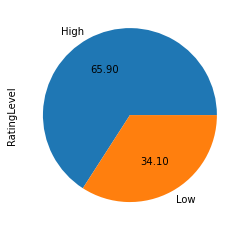

In [13]:
df['RatingLevel'] = pd.cut(x=df['Rating'],
                     bins=[1, 6, 10],
                     labels=['Low', 'High'])

#Balanced or Imbalanced Dataset
print(color.BLUE + color.BOLD + "Classification of Rating Level:" + color.END)
count = df['RatingLevel'].value_counts()
print(count)
count.plot.pie(autopct='%.2f')

<h4>Data Visualization</h4>

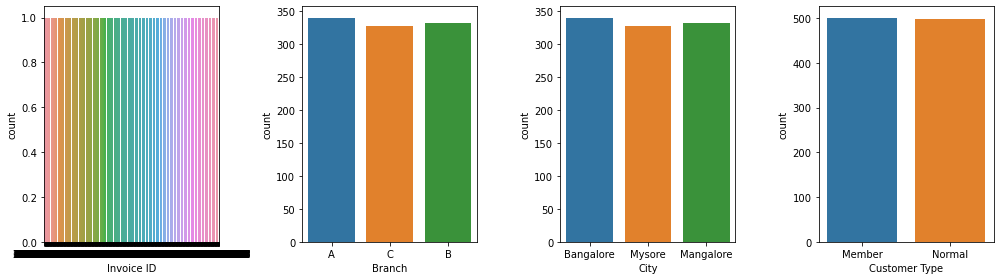

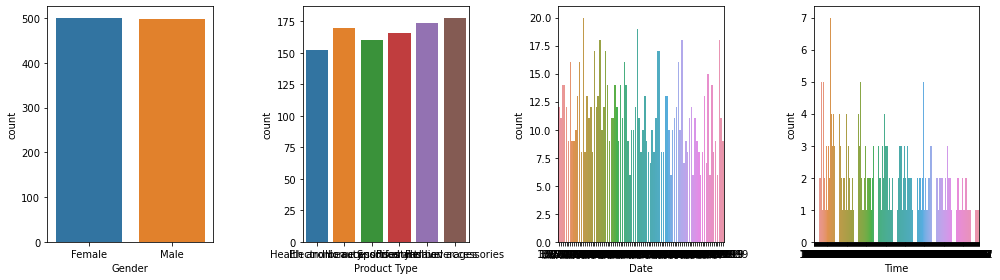

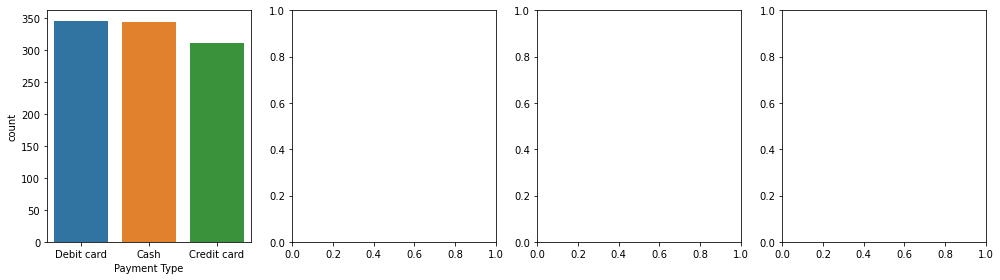

In [14]:
#Count Plots (for categorical attributes)

plt.rcParams["figure.figsize"] = [14.00, 4.0]
plt.rcParams["figure.autolayout"] = True

index = 0
graphsInARow = 4

for attr in categoricalList:
    
    if (index % graphsInARow == 0):
        f, ax = plt.subplots(1, graphsInARow)
        
    sns.countplot(x=attr, data=df, ax = ax[index % graphsInARow])
    index = index + 1
    
    if (index % graphsInARow == 0):
        plt.show()

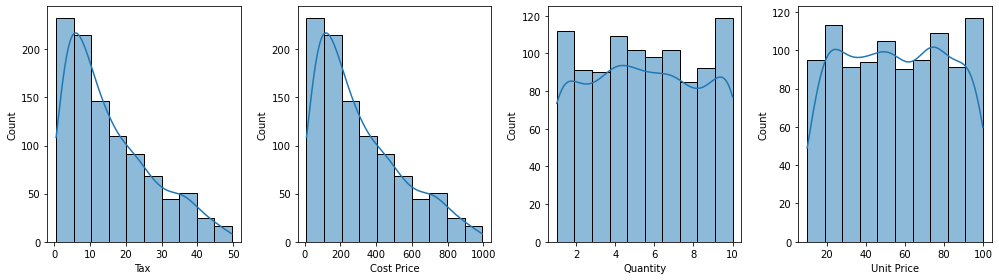

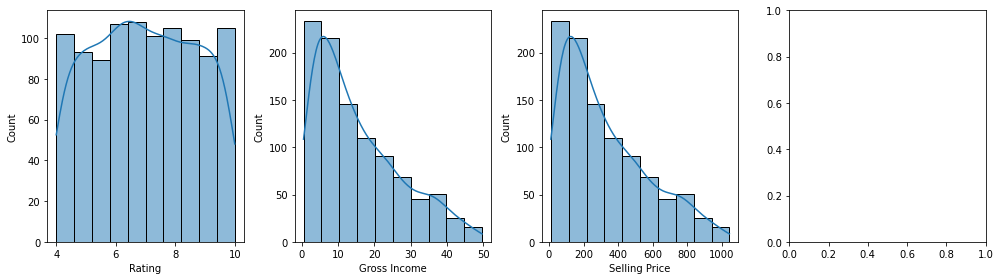

In [15]:
#Histogram Distribution (for Continuous Attributes)
plt.rcParams["figure.figsize"] = [14.00, 4.0]
plt.rcParams["figure.autolayout"] = True

index = 0
graphsInARow = 4

for attr in numericalList:
    if (index % graphsInARow == 0):
        f, ax = plt.subplots(1, graphsInARow)
    sns.histplot(data=df[attr], bins=10, kde=True, ax = ax[index % graphsInARow])
    index = index + 1
    if (index % graphsInARow == 0):
        plt.show()

                                         Correlation Using HeatMap                                         


<AxesSubplot:>

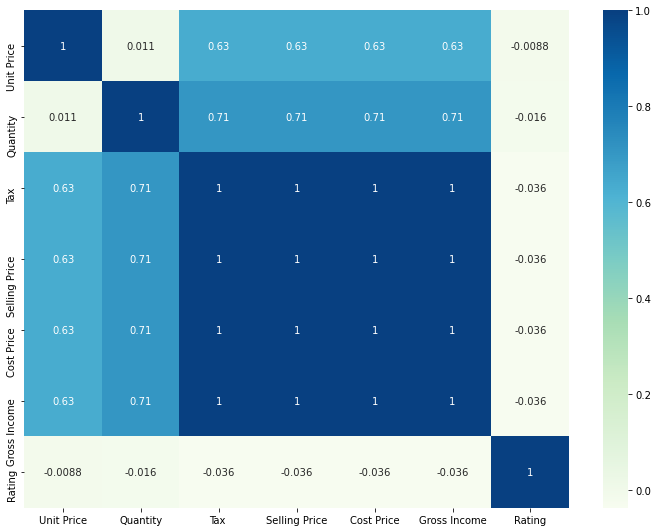

In [16]:
#Correlation of the features in the dataset
corr = df.corr()

corrTxt = color.BLUE + color.BOLD + "Correlation Using HeatMap" + color.END
print(corrTxt.center(120))

#Visualizing correlation using Heatmap
plt.figure(figsize=(10,7.5))
sns.heatmap(corr, annot=True, cmap='GnBu')

<h2>3) Data Wrangling</h2>

In [17]:
#Count of NaN/Null values from dataset
print(color.BLUE + color.BOLD + "\nCount of NaN/Null values for each feature:" + color.END)
print(df.isna().sum())


Count of NaN/Null values for each feature:
Invoice ID       0
Branch           0
City             0
Customer Type    0
Gender           0
Product Type     0
Unit Price       0
Quantity         0
Tax              0
Selling Price    0
Date             0
Time             0
Payment Type     0
Cost Price       0
Gross Income     0
Rating           0
RatingLevel      0
dtype: int64


In [18]:
# Checking for duplicates
df.duplicated().sum()

0

In [19]:
# Dropping the attributes that has a unique number(number assignment) for all the rows or attributes derivable from other features 
df=df.drop(['Invoice ID','Branch', 'Date', 'Time'], axis=1)

In [20]:
df.shape

(1000, 13)

In [21]:
df.head(2)

City Customer Type  Gender            Product Type  Unit Price  \
0  Bangalore        Member  Female       Health and beauty       74.69   
1     Mysore        Normal  Female  Electronic accessories       15.28   

   Quantity     Tax   Selling Price Payment Type  Cost Price  Gross Income  \
0         7  26.1415       548.9715   Debit card      522.83       26.1415   
1         5   3.8200        80.2200         Cash       76.40        3.8200   

   Rating RatingLevel  
0     9.1        High  
1     9.6        High

<h2>4) Clustering </h2>

In [22]:
#Copy of df
dfCopy = df.copy()

for column in dfCopy.columns:
    #If Column data type is int or float continue
    if dfCopy[column].dtype == 'int64' or dfCopy[column].dtype == 'float64':
        continue
        #If Column data type is object, encode and transform it
    dfCopy[column] = LabelEncoder().fit_transform(dfCopy[column].astype(str)) 

In [23]:
dfCopy.head(2)

City  Customer Type  Gender  Product Type  Unit Price  Quantity     Tax   \
0     0              0       0             3       74.69         7  26.1415   
1     2              1       0             0       15.28         5   3.8200   

   Selling Price  Payment Type  Cost Price  Gross Income  Rating  RatingLevel  
0       548.9715             2      522.83       26.1415     9.1            0  
1        80.2200             0       76.40        3.8200     9.6            0

In [24]:
# Scaling is done
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dfCopy)
scaled_features.shape

(1000, 13)

In [25]:
scaled_features_df = pd.DataFrame(scaled_features)
scaled_features_df.columns = ['City', 'Customer Type', 'Gender', 'Product Type', 'Unit Price',
       'Quantity', 'Tax ', 'Selling Price', 'Payment Type', 'Cost Price',
       'Gross Income', 'Rating', 'RatingLevel']
scaled_features_df.head()

City  Customer Type    Gender  Product Type  Unit Price  Quantity  \
0 -1.208970      -0.998002 -0.998002      0.319617    0.718160  0.509930   
1  1.238338       1.002002 -0.998002     -1.430109   -1.525303 -0.174540   
2 -1.208970       1.002002  1.002002      0.902859   -0.352781  0.509930   
3 -1.208970      -0.998002  1.002002      0.319617    0.096214  0.852165   
4 -1.208970       1.002002  1.002002      1.486101    1.156959  0.509930   

       Tax   Selling Price  Payment Type  Cost Price  Gross Income    Rating  \
0  0.919607       0.919607      1.203528    0.919607      0.919607  1.238443   
1 -0.987730      -0.987730     -1.205937   -0.987730     -0.987730  1.529527   
2  0.071446       0.071446     -0.001205    0.071446      0.071446  0.248760   
3  0.675780       0.675780      1.203528    0.675780      0.675780  0.830927   
4  1.267125       1.267125      1.203528    1.267125      1.267125 -0.973790   

   RatingLevel  
0    -0.719340  
1    -0.719340  
2    -0.719340  
3    -0.719340  
4     1.390162

<h4> 1. K-Means Clustering </h4>

In [26]:
range_n_clusters = [2, 3, 4]
silhouette_avg_mean = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans1 = KMeans(n_clusters = num_clusters, max_iter = 50)
    kmeans1.fit(dfCopy)
    
    cluster_labels = kmeans1.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(dfCopy, cluster_labels).round(3)
    silhouette_avg_mean.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.644
For n_clusters=3, the silhouette score is 0.591
For n_clusters=4, the silhouette score is 0.548


<h4> 2. K-Medoids Clustering </h4>

In [27]:
range_n_clusters = [2, 3, 4]
silhouette_avg_med = []
for num_clusters in range_n_clusters:
    
    kmedoids1 = KMedoids(num_clusters).fit(dfCopy)
    cluster_labels = kmedoids1.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(dfCopy, cluster_labels).round(3)
    silhouette_avg_med.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.631
For n_clusters=3, the silhouette score is 0.582
For n_clusters=4, the silhouette score is 0.535


<h4> 3. Agglomerative Hierarchical Clustering (AHC) </h4>

In [28]:
range_n_clusters = [2, 3, 4]
silhouette_avg_clust = []
for num_clusters in range_n_clusters:
    cluster1 = AgglomerativeClustering(n_clusters = num_clusters, affinity='euclidean', linkage='ward')
    cluster1.fit_predict(dfCopy)
    cluster_labels = cluster1.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(dfCopy, cluster_labels).round(3)
    silhouette_avg_clust.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.639
For n_clusters=3, the silhouette score is 0.59
For n_clusters=4, the silhouette score is 0.518


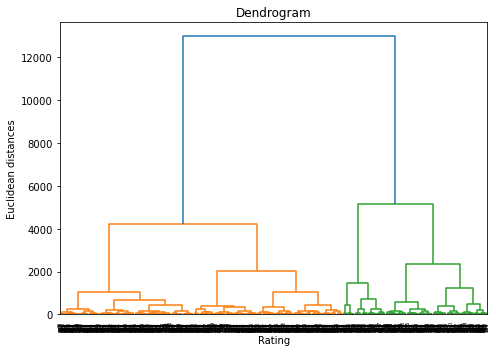

In [29]:
plt.figure(figsize=(7, 5))

dendrogram = sch.dendrogram(sch.linkage(dfCopy, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Rating')
plt.ylabel('Euclidean distances')
plt.show()

<h4> Comparison of 3 Clustering methods using Elbow Method </h4>

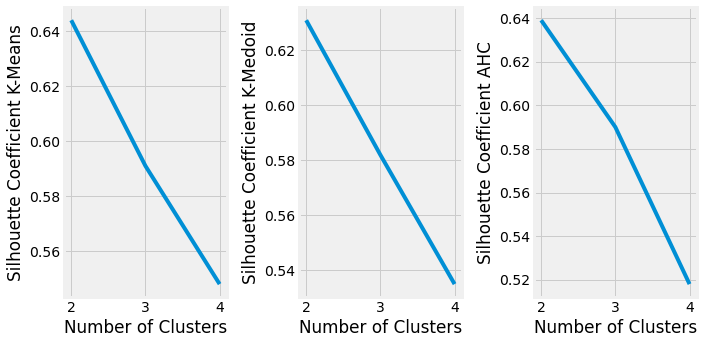

In [30]:
plt.figure(figsize=(10, 5))

plt.style.use("fivethirtyeight")
plt.subplot(1,3,1)
plt.plot(range(2, 5), silhouette_avg_mean)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient K-Means")

plt.style.use("fivethirtyeight")
plt.subplot(1,3,2)
plt.plot(range(2, 5), silhouette_avg_med)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient K-Medoid")

plt.style.use("fivethirtyeight")
plt.subplot(1,3,3)
plt.plot(range(2, 5), silhouette_avg_clust)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient AHC")

plt.subplots_adjust(left=1,
                    bottom=0.1,
                    right=2,
                    top=0.9,
                    wspace=1,
                    hspace=1)
plt.show()

Best Silhouette Score

In [31]:
features, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42
)
scaled_features1 = scaler.fit_transform(features)

In [32]:
# Best score is for k = 2
kmeans1 = KMeans(n_clusters=2)
kmedoids1 = KMedoids(n_clusters=2)
ahc1 = AgglomerativeClustering(n_clusters=2)

# Fit the algorithms to the features
kmeans1.fit(scaled_features1)
kmedoids1.fit(scaled_features1)
ahc1.fit_predict(scaled_features1)

# Compute the silhouette scores for each algorithm
kmeans_silhouette1 = silhouette_score(
    scaled_features1, kmeans1.labels_).round(3)
kmedoids_silhouette1 = silhouette_score(
   scaled_features1, kmedoids1.labels_).round (3)
ahc_silhouette1 = silhouette_score(
   scaled_features1, ahc1.labels_).round (3)

In [33]:
print(kmeans_silhouette1)
print(kmedoids_silhouette1)
print(ahc_silhouette1)

0.497
0.473
0.457


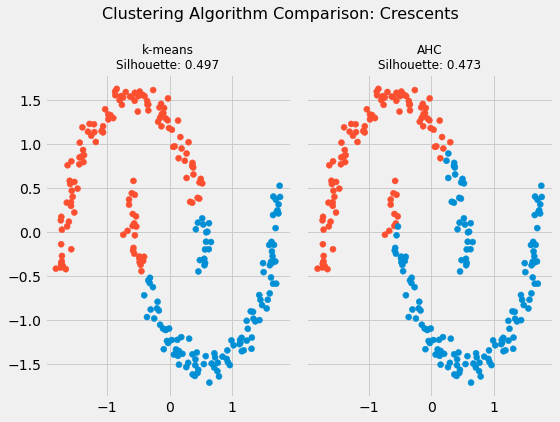

In [34]:
# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",
}
# The k-means plot
kd_colors = [fte_colors[label] for label in kmeans1.labels_]
ax1.scatter(scaled_features1[:, 0], scaled_features1[:, 1], c=kd_colors)
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette1}", fontdict={"fontsize": 12}
)

# The ahc plot
ahc_colors = [fte_colors[label] for label in kmedoids1.labels_]
ax2.scatter(scaled_features1[:, 0], scaled_features1[:, 1], c=ahc_colors)
ax2.set_title(
    f"AHC\nSilhouette: {kmedoids_silhouette1}", fontdict={"fontsize": 12}
)
plt.show()

<h2>5) Feature Selection Engineering </h2>

<h4> Feature Selection 1 - Filter Method (Removing Higher Correlated features) </h4>

In [35]:
def featSelectFilter(dfFeat1):
    # Create correlation matrix
    corr_matrix = corr.abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

    # Get features with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

    print(color.BLUE + color.BOLD + 'Features removed since correlation is higher:' + color.END)
    print(to_drop)

    # Drop features 
    dfFeat1.drop(list(to_drop), axis=1, inplace=True)
    
    #Size of the Dataset
    print(color.BLUE + color.BOLD + "\nSize of Dataset:" + color.END)
    print(dfFeat1.shape)
    
    return dfFeat1

In [36]:
#Transform the non numerical data into numerical
def transformToNumerical(dfFeat1):
    for column in dfFeat1.columns:
        #If Column data type is Int i.e, numerical continue
        if dfFeat1[column].dtype == 'int64' or dfFeat1[column].dtype == 'float64': 
            continue
        #If Column data type is not Int, encode and transform to Numerical
        dfFeat1[column] = LabelEncoder().fit_transform(dfFeat1[column].astype(str)) 
    
    return dfFeat1

In [37]:
def minMaxScaler(dfFeat1):
    # Using Min Max Scaler
    min_max_scaler = MinMaxScaler()
    min_max_scaled = min_max_scaler.fit_transform(dfFeat1)

    # Creating new Data frame with the scaled value
    FE1_Norm = pd.DataFrame(min_max_scaled, columns = dfFeat1.columns)

    return FE1_Norm

In [38]:
#Split the entire dataset to Train and Test 
def splitTrainTest(dfFeat1, dfFeat2):
    #Splitting the dataset
    X = dfFeat1.iloc[:, 0:dfFeat2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    Y = dfFeat1.iloc[:, -1]
    
    #Split the data into 75% training and 25% testing
    return train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [39]:
#Dimensionality Reduction using PCA
def dimReductionPCA(X_train, X_test):
    # Make an instance of the Model
    pca = PCA(.95)

    pca.fit(X_train)

    X_train = pca.transform(X_train) #PCA transformation on Train Set
    X_test = pca.transform(X_test) #PCA transformation on Test Set

    #How much information (variance) attributed to each of the principal components
    explained_variance = pca.explained_variance_ratio_
    print(color.BLUE + color.BOLD + 'Variance attributed to each of the principal components:' + color.END)
    print(explained_variance)
    
    return X_train, X_test

In [40]:
#Handling the Dataset Imbalance Using Hybridization: SMOTE + Tomek Links
def handleClassImbalance(X_train, Y_train):
    
    counter = Counter(Y_train) #Before Sampling, count of Y_train
    print(color.BLUE + color.BOLD + 'Before Sampling:' + color.END)
    print(counter)

    #Oversampling the train dataset using SMOTE + Tomek
    #To get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE
    smtom = SMOTETomek(random_state=0)  
    X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, Y_train) #Fit the resampled model

    counter = Counter(y_train_smtom) #After Sampling, Count of y_train_smtom
    print(color.BLUE + color.BOLD + 'After Sampling:' + color.END)
    print(counter)
    
    return X_train_smtom, y_train_smtom

In [41]:
# Train the model using Random Forest classifier
# This meta estimator fits a number of decision tree classifiers on sub-samples of the
# dataset and uses averaging to improve the predictive accuracy and control over-fitting

def randomForestModel(X_train_smtom, y_train_smtom):
    #Number of trees given as '10' with criterion 'entropy' and seed for random generator is set as '0' 
    randomforest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0) 
    randomforest.fit(X_train_smtom, y_train_smtom)

    return randomforest

In [42]:
#Plotting top features that help in predicting using the Random Forest Built-in Feature Importance 

def importantFeatures(randomforest, dfFeat1):
    #Determine the feature importance values
    importances = randomforest.feature_importances_ 
    
    #Create a dictionary with the importances values
    important_features_dict = {}
    for idx, val in enumerate(importances): 
        important_features_dict[idx] = val
    
    #Sort the feature importances in descending order
    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)[1:]

    important_features = dfFeat1.columns[important_features_list]

    #Visualize the top 6 feature importance using bar chart
    feat_importances = pd.Series(importances[important_features_list], index=important_features)
    feat_importances.nlargest(6).plot(kind='barh')
    plt.xlabel('Feature Importance')
    plt.title('Top Features With Higher Random Forest Feature Importance')
    plt.show()

In [43]:
# Create Machine Learning models – Logistic regression and Decision tree to predict

def mlPredict(X_train_smtom, y_train_smtom, Y_test):
    cv_dataFrames = []
    
    # Prepare Machine Learning models – Logistic regression and Decision tree
    models = []
    
    #Parametric Supervised learning model based on probability
    models.append(('Logistic Regression(LR)', LogisticRegression()))
    #Non-Parametric Supervised learning model by learning simple decision rules inferred from the data features
    models.append(('Decision Tree(CART)', DecisionTreeClassifier())) 

    results = []
    mNames = [] #List for collecting model names
    
    #List of scoring metrics for comparison of models
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc'] 
    
    targ_names = ['Low', 'High'] #List of target values
    
    for mName, model in models: #Looping through each of the models
        
            #Split the dataset into '5' folds and Each fold is used once as a validation while the '5 - 1' 
            #remaining folds form the training set
            #Shuffle is set to 'True' to shuffle the data before splitting into batches
            #Random_state affects the ordering of the indices, which controls the randomness of each fold
            kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210) 
            
            #Evaluate metrics by cross-validation
            cv_res = model_selection.cross_validate(model, X_train_smtom, y_train_smtom, cv=kfold, scoring=scoring)
            
            #Fit the model and predict the label of test set
            ml = model.fit(X_train_smtom, y_train_smtom) 
            y_pred = ml.predict(X_test)
            
            print(color.BLUE + color.BOLD + mName + color.END)
            
            #Number of correct and incorrect predictions compared wih Actual class and Predicted class
            cm = confusion_matrix(Y_test, y_pred)

            TN = cm[0][0] #True Negative(Predicted No, Actual No, classifier is getting things right)
            TP = cm[1][1] #True Positive(Predicted Yes, Actual Yes, classifier is getting things right)
            FN = cm[1][0] #False Negative(Predicted No, Actual Yes, classifier is getting things wrong i.e, mislabelling)
            FP = cm[0][1] #False Positive(Predicted Yes, Actual No, classifier is getting things wrong i.e, mislabelling)

            print(color.BOLD + "\nConfusion Matrix:" + color.END)
            
            column_names = ['Predicted Low', 'High']
            row_names    = ['Actual Low', 'High']
            
            cm_df = pd.DataFrame(cm, columns=column_names, index=row_names)
            
            print(cm_df)
            
            #Accuracy determines how often is classifier correct, (TP+TN)/Total
            print(color.BOLD + "\nAccuracy:" + color.END)
            print(round(accuracy_score(Y_test, y_pred) * 100, 2),"%")
            
            #Return the list of scores calculated for each cv='10' folds, estimator object 
            #implementing ‘fit’ and n_jobs='-1' means using all processors
            cross_val_lr = cross_val_score(estimator = model, X = X_train_smtom, y = y_train_smtom, cv = 10, n_jobs = -1)
            print(color.BOLD + "\nCross Validation Accuracy:" + color.END)
            print(round(cross_val_lr.mean() * 100 , 2),"%")
            
            #Report showing the main classification metrics with the target names 'Yes' and 'No'
            print(color.BOLD + "\nClassification Report:" + color.END)
            print(classification_report(Y_test, y_pred, target_names=targ_names))
            
            #Get False Positive Rates and True Postive rates for the Classifiers
            #By roc_curve module by passing the test dataset and the predicted data through it
            print(color.BOLD + "\nReceiver Operating Characteristic(ROC):" + color.END)
            false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred)
            
            #Ploting ROC Curves with False Positive Rate on X-axis and True Positive Rate on Y-axis
            title = 'Receiver Operating Characteristic(ROC) - ' + mName
            plt.subplots(1, figsize=(7,5))
            plt.title(title)
            plt.plot(false_positive_rate1, true_positive_rate1)
            plt.plot([0, 1], ls="--")
            plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            
            results.append(cv_res) #Appending the cross validation metrics
            mNames.append(mName) #Appending each of the model names

            dataFrame = pd.DataFrame(cv_res) #Create data frame of cross validation results
            dataFrame['model'] = mName #Add the model name to dataframe
            cv_dataFrames.append(dataFrame) #Append each of the data frames
            
            result = pd.concat(cv_dataFrames, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    return result

In [44]:
#Comparison of Performance of Logistic Regression and Decision tree models

def ml_ModelsComparison(result):
    mlValues = []
    
    #Iterating through result values and append the values of each models to mlValues[]
    for model in list(set(result.model.values)): 
        m_dataFrame = result.loc[result.model == model]
        mlValue = m_dataFrame.sample(n=30, replace=True)
        mlValues.append(mlValue)

    m_dataFrame = pd.concat(mlValues, ignore_index=True) #Concatenate the the dataframes object ingnoring index
    
    #Massage a DataFrame into a format where identifier variable is 'model', variable column 'metrics' 
    #and value column 'values'
    perf_results = pd.melt(m_dataFrame,id_vars=['model'],var_name='metrics', value_name='values')
    
    tym_metrics = ['fit_time','score_time'] # Fit time Metrics
    
    #Performance Metrics
    perf_results_nofit = perf_results.loc[~perf_results['metrics'].isin(tym_metrics)] # Get dataframe without fit data
    perf_results_nofit = perf_results_nofit.sort_values(by='values') #Sort the performance result on its values

    #Visualization of Comparison of LR and CART Model using BoxPlot
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    g = sns.boxplot(x="model", y="values", hue="metrics", data=perf_results_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of LR and CART Model by Classification Metric')

    return perf_results_nofit, m_dataFrame

<h4> Feature Selection 2 - Chi-Square and Mutual Info </h4>

In [45]:
def select_featureschi(X_train, y_train):
    fs = SelectKBest(score_func=chi2, k=5)
    fs.fit_transform(X_train, y_train)
    return fs

def selected_features_chi2(dfFeat2):
    #Splitting the dataset
    X = dfFeat2.iloc[:, 0:dfFeat2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    y = dfFeat2.iloc[:, -1]

    fs = select_featureschi(X, y)

    selected_features_chi2 = list(X.columns[fs.get_support(indices=True)])
    return selected_features_chi2

In [46]:
def select_featuresinfo(X_train, y_train):
    fs = SelectKBest(score_func=mutual_info_classif, k=5)
    fs.fit_transform(X_train, y_train)
    return fs

def selected_features_mutual_info(dfFeat2):
    #Splitting the dataset
    X = dfFeat2.iloc[:, 0:dfFeat2.shape[1]]
    X = X.drop(['RatingLevel','Rating'], axis=1)
    y = dfFeat2.iloc[:, -1]

    fs = select_featuresinfo(X, y)
    
    selected_features_mutual_info = list(X.columns[fs.get_support(indices=True)])
    return selected_features_mutual_info

Calling the functions

In [47]:
#Feature Selection 1 - Filter Method(Removing Higher Correlated features)
dfFeature1 = df.copy() #Create a copy of dataset
dfFeature1 = featSelectFilter(dfFeature1)

Features removed since correlation is higher:
['Selling Price', 'Cost Price', 'Gross Income']

Size of Dataset:
(1000, 10)


In [48]:
#Feature Encoding (To Numerical)
dfFeature1 = transformToNumerical(dfFeature1)
dfFeature1.head(2)

City  Customer Type  Gender  Product Type  Unit Price  Quantity     Tax   \
0     0              0       0             3       74.69         7  26.1415   
1     2              1       0             0       15.28         5   3.8200   

   Payment Type  Rating  RatingLevel  
0             2     9.1            0  
1             0     9.6            0

In [49]:
dfFeature1 = minMaxScaler(dfFeature1)
dfFeature1.head(2)

City  Customer Type  Gender  Product Type  Unit Price  Quantity      Tax   \
0   0.0            0.0     0.0           0.6    0.718847  0.666667  0.521616   
1   1.0            1.0     0.0           0.0    0.057855  0.444444  0.067387   

   Payment Type    Rating  RatingLevel  
0           1.0  0.850000          0.0  
1           0.0  0.933333          0.0

In [50]:
#Splitting the Dataset to Train and Test
X_train, X_test, Y_train, Y_test = splitTrainTest(dfFeature1, dfFeature1)

In [51]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.22059842 0.19658315 0.14265224 0.14076454 0.12170646 0.0977056
 0.07657132]


In [52]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0.0: 510, 1.0: 240})
After Sampling:
Counter({1.0: 465, 0.0: 465})


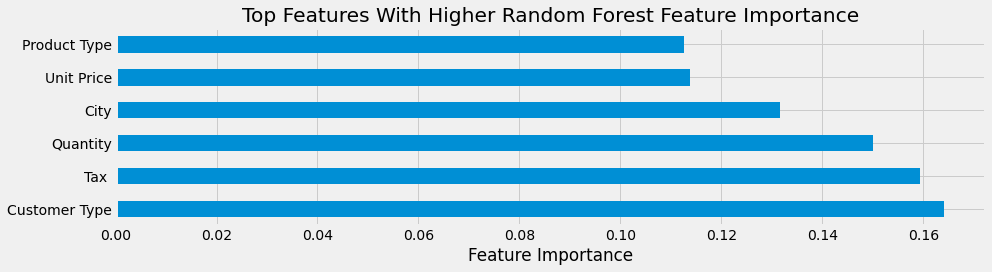

In [53]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFeature1)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Low  High
Actual Low             88    61
High                   50    51

Accuracy:
55.6 %

Cross Validation Accuracy:
52.26 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.64      0.59      0.61       149
        High       0.46      0.50      0.48       101

    accuracy                           0.56       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.56      0.56      0.56       250


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Low  High
Actual Low            104    45
High                   60    41

Accuracy:
58.0 %

Cross Validation Accuracy:
66.24 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.63      0.70      0.66       149
        High       0.48      0.41      0.44       101

    accuracy                          

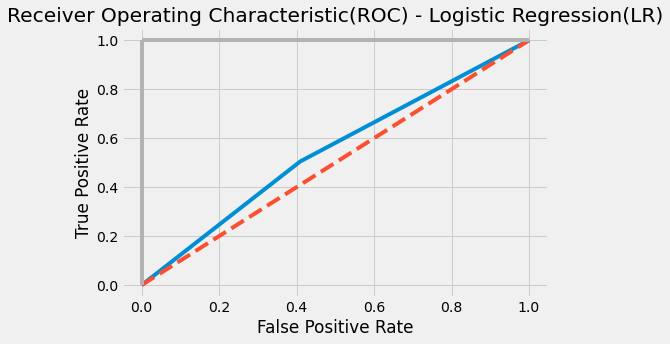

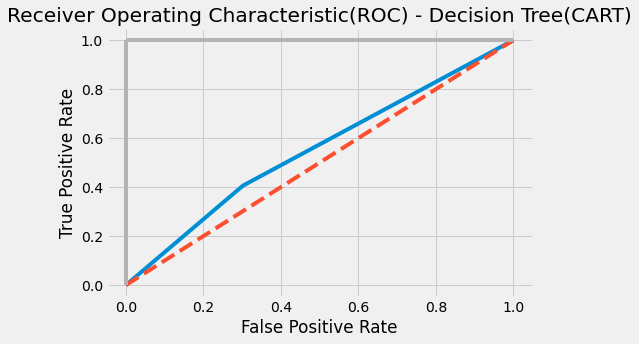

In [54]:
result = mlPredict(X_train_smtom, y_train_smtom, Y_test)

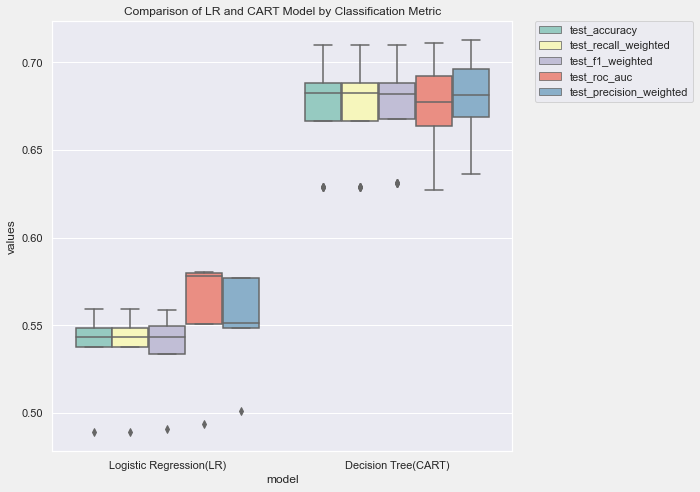

In [55]:
#Machine Learning models – Logistic regression and Decision tree to predict attrition and Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

<h4> Comparison of Performance metrics </h4>

In [56]:
metricValues = list(set(perf_results_nofit.metrics.values))
#aggregate metric values with standard deviation and mean
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean]) 

test_accuracy           test_recall_weighted  \
                                  std      mean                  std   
model                                                                  
Decision Tree(CART)          0.025496  0.671147             0.025496   
Logistic Regression(LR)      0.011616  0.541756             0.011616   

                                  test_roc_auc            \
                             mean          std      mean   
model                                                      
Decision Tree(CART)      0.671147     0.026472  0.669467   
Logistic Regression(LR)  0.541756     0.018999  0.567423   

                        test_precision_weighted           test_f1_weighted  \
                                            std      mean              std   
model                                                                        
Decision Tree(CART)                    0.024297  0.674717         0.024513   
Logistic Regression(LR)                0.016826  0.559151         0.012181   

                                   
                             mean  
model                              
Decision Tree(CART)      0.671382  
Logistic Regression(LR)  0.540572

In [87]:
dfFeature2 = df
dfFeature2 = transformToNumerical(dfFeature2)
featSelect2 = selected_features_chi2(dfFeature2) + selected_features_mutual_info(dfFeature2)
featSelect2 = list(set(featSelect2))
dfFeature2 = dfFeature2[featSelect2]
dfFeature2.head(2)

Tax   Customer Type  Product Type  Cost Price  Unit Price  Gross Income  \
0  26.1415              0             3      522.83       74.69       26.1415   
1   3.8200              1             0       76.40       15.28        3.8200   

   Selling Price  
0       548.9715  
1        80.2200

In [88]:
dfFeature2 = minMaxScaler(dfFeature2)
dfFeature2.head(2)

Tax   Customer Type  Product Type  Cost Price  Unit Price  \
0  0.521616            0.0           0.6    0.521616    0.718847   
1  0.067387            1.0           0.0    0.067387    0.057855   

   Gross Income  Selling Price  
0      0.521616       0.521616  
1      0.067387       0.067387

In [89]:
#Splitting the Dataset to Train and Test
X = dfFeature2.iloc[:, 0:dfFeature2.shape[1]]
Y = df.iloc[:, -1]
    
#Split the data into 75% training and 25% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [90]:
#PCA Dimensionality Reduction
X_train, X_test = dimReductionPCA(X_train, X_test)

Variance attributed to each of the principal components:
[0.3965098  0.36482893 0.17416625 0.06449501]


In [91]:
#Handling Imbalanced Dataset
X_train_smtom, y_train_smtom = handleClassImbalance(X_train, Y_train)

Before Sampling:
Counter({0: 510, 1: 240})
After Sampling:
Counter({1: 435, 0: 435})


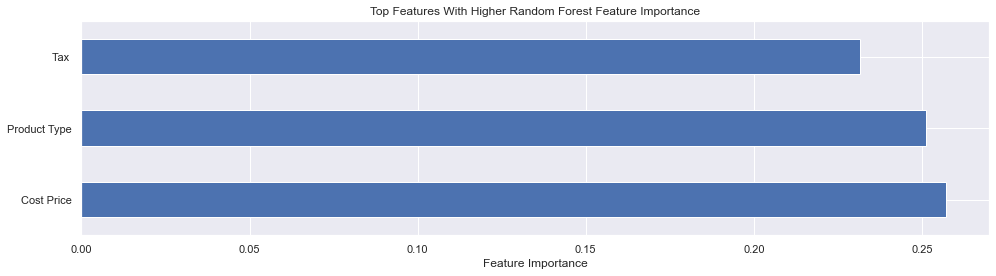

In [92]:
#RandomForest Model for important features
randomforest = randomForestModel(X_train_smtom, y_train_smtom)
importantFeatures(randomforest, dfFeature2)

Logistic Regression(LR)

Confusion Matrix:
            Predicted Low  High
Actual Low             83    66
High                   53    48

Accuracy:
52.4 %

Cross Validation Accuracy:
53.56 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.61      0.56      0.58       149
        High       0.42      0.48      0.45       101

    accuracy                           0.52       250
   macro avg       0.52      0.52      0.51       250
weighted avg       0.53      0.52      0.53       250


Receiver Operating Characteristic(ROC):
Decision Tree(CART)

Confusion Matrix:
            Predicted Low  High
Actual Low             80    69
High                   65    36

Accuracy:
46.4 %

Cross Validation Accuracy:
71.49 %

Classification Report:
              precision    recall  f1-score   support

         Low       0.55      0.54      0.54       149
        High       0.34      0.36      0.35       101

    accuracy                          

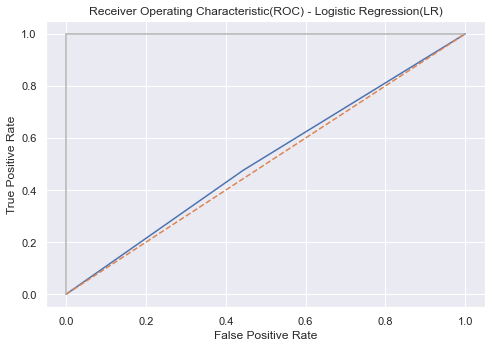

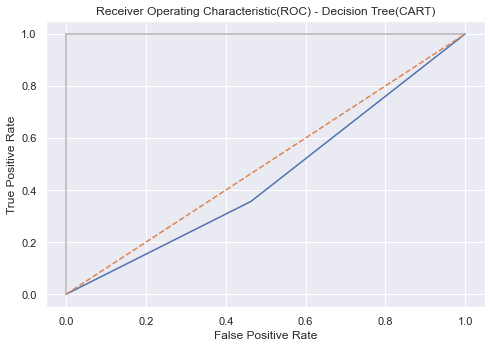

In [93]:
#Implement machine learning models to predict and gets the result of model and its performance metric values
result = mlPredict(X_train_smtom, y_train_smtom, Y_test) 

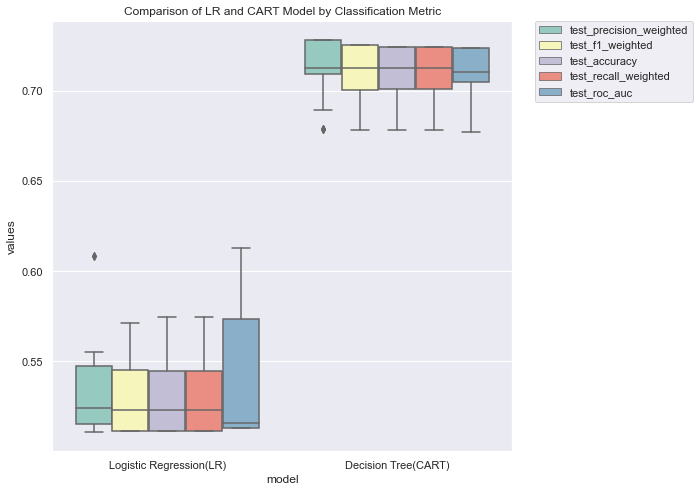

In [94]:
#Machine Learning models – Logistic regression and Decision tree to predict attrition and Comparison of Performance
perf_results_nofit, m_dataFrame = ml_ModelsComparison(result)

In [95]:
#Comparison of Performance metrics
metricValues = list(set(perf_results_nofit.metrics.values))
#aggregate metric values with standard deviation and mean
m_dataFrame.groupby(['model'])[metricValues].agg([np.std, np.mean])

test_accuracy           test_recall_weighted  \
                                  std      mean                  std   
model                                                                  
Decision Tree(CART)          0.015858  0.708046             0.015858   
Logistic Regression(LR)      0.019488  0.527969             0.019488   

                                  test_roc_auc            \
                             mean          std      mean   
model                                                      
Decision Tree(CART)      0.708046     0.015845  0.707812   
Logistic Regression(LR)  0.527969     0.033951  0.538934   

                        test_precision_weighted           test_f1_weighted  \
                                            std      mean              std   
model                                                                        
Decision Tree(CART)                    0.016731  0.710983         0.016312   
Logistic Regression(LR)                0.025669  0.532402         0.019132   

                                   
                             mean  
model                              
Decision Tree(CART)      0.708206  
Logistic Regression(LR)  0.527890